# COMP7220/8220 Major Project.

Student Name: Duc Dan Nguyen

Student ID: 46864660

Kaggle Username: Duc Dan Nguyen

# Introduction

This notebook is for the major project submission for COMP7220/8220, on the image dataset and task.  It contains the following sections:

*   Section to get the data from Kaggle ( can skip this when reading the report).
*   Code from Code Stub to run the Project ( can skip this part when reading the report).
*   Dataset Exploration.
*   A description of the selected Conventional ML models, for both Coarse and Fine labels.
*   Some notes about the choices made in building the conventional ML model.
*   A description of the selected deep learning model, for both Coarse and Fine Labels.
*   Some notes about the choices made in building the deep model.
*   A discussion of the performance of the models, for both Coarse and Fine Labels.



# Get the data from Kaggle

Mount the Google Drive files

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Now upload the kaggle.json file

In [ ]:
from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

Make sure kaggle.json file is present

In [ ]:
!ls -lha kaggle.json

ls: kaggle.json: No such file or directory


Install kaggle API client

In [36]:
!pip install -q kaggle

kaggle API client expects the file to be in ~/.kaggle so move it there

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

We need to set permissions

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

Check your directory before downloading the datasets

In [ ]:
!pwd

/content


Download the coarse dataset

In [ ]:
!kaggle competitions download -c living-thing-classification-coarse

100% 5.40G/5.40G [03:29<00:00, 40.1MB/s]
100% 5.40G/5.40G [03:29<00:00, 27.7MB/s]


In [ ]:
!unzip -q living-thing-classification-coarse.zip 

# Code Stub

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

%matplotlib inline


Version:  2.12.0
Eager mode:  True
GPU is available


In [189]:
batch_size = 64
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8

root = Path('public')


Some potentially useful functions for reading data from files.

In [3]:
def load_target_names(path='public/info.json'):
    with open(path) as f:
        info = json.load(f)
    return info['fine'], info['coarse']


def load_image(file_path, image_size=112):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [image_size, image_size])
    return img


def create_dataset_tf(split, fine_grained, batch_size=32, image_size=112):
    df = pd.read_csv(root / f"{split}.csv")
    file_paths = df.filename.map(lambda fn: str(root / split / fn))
    labels = df.fine if fine_grained else df.coarse

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(lambda x, y: (
        load_image(x, image_size=image_size), y))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


def create_dataset_sklearn(split, fine_grained, image_size=48, percent=0.1):
    dataset = create_dataset_tf(
        split=split, fine_grained=fine_grained, batch_size=1000, image_size=image_size)
    dataset = dataset.map(lambda x, y: (tf.image.rgb_to_grayscale(x), y))
    X = None
    Y = None
    n_batches = int(len(dataset) * percent)
    for x, y in dataset.take(n_batches):
        x, y = x.numpy(), y.numpy()
        x = x.reshape(x.shape[0], -1)
        X = x if X is None else np.vstack([X, x])
        Y = y if Y is None else np.hstack([Y, y])

    return X, Y


In [4]:
fine_names, coarse_names = load_target_names()
print(coarse_names)


['Aves', 'Reptilia', 'Mammalia', 'Arachnida', 'Magnoliopsida', 'Insecta', 'Liliopsida', 'Pinopsida']


In [5]:
print(fine_names)


['Scolopacidae', 'Laridae', 'Accipitridae', 'Anatidae', 'Corvidae', 'Icteridae', 'Picidae', 'Colubridae', 'Sciuridae', 'Rosaceae', 'Cyperaceae', 'Brassicaceae', 'Sphingidae', 'Orchidaceae', 'Apidae', 'Papilionidae', 'Orobanchaceae', 'Liliaceae', 'Apocynaceae', 'Poaceae', 'Araneidae', 'Pinaceae', 'Asparagaceae', 'Acrididae', 'Hesperiidae', 'Rubiaceae', 'Onagraceae', 'Libellulidae', 'Fagaceae', 'Cactaceae', 'Lycaenidae', 'Coenagrionidae', 'Boraginaceae', 'Ranunculaceae', 'Polygonaceae', 'Pieridae', 'Caryophyllaceae', 'Lamiaceae', 'Noctuidae', 'Apiaceae', 'Malvaceae', 'Geometridae', 'Plantaginaceae', 'Euphorbiaceae', 'Crambidae', 'Parulidae', 'Erebidae', 'Ericaceae', 'Passerellidae', 'Tyrannidae']


# Explore and Visualize the Data to Gain Insights

## Coarse-grained

### Training set

We can look at the first 16 instances from the training set.

In [74]:
import seaborn as sns

# Read the train.csv file into a DataFrame
df = pd.read_csv(root / "train.csv")

# Map the coarse labels to their corresponding names using a dictionary
df['coarse_name'] = df['coarse'].map(dict(zip(list(range(8)), coarse_names)))

# Map the fine labels to their corresponding names using a dictionary
df['fine_name'] = df['fine'].map(dict(zip(list(range(50)), fine_names)))

# Display the first few rows of the DataFrame
df.head(16)


filename  coarse  fine    coarse_name   
0   658b2f15f08dc6b8264b4913b52eb337d7a50692.jpg       5    41        Insecta  \
1   cf7221725164ac5bf8e432decf769611c3ba2f4d.jpg       6    19     Liliopsida   
2   ac0b7d9399a53bc200419253976f64230109bfae.jpg       1     7       Reptilia   
3   b5b968eb2fb0bcca175c115c103f5a33ea8830ba.jpg       5    30        Insecta   
4   a09e9a5ce49ebbf7e774c13eb5a9fc97b152d609.jpg       4    42  Magnoliopsida   
5   92e9a925275d9d96c48db418eb55cbdaafb72867.jpg       5    41        Insecta   
6   0f57f06790fb1b223901d79d6c9624bb36a2e2b8.jpg       4    37  Magnoliopsida   
7   c91c52f8eb3ed89092061d8db24ec131d171755d.jpg       6    10     Liliopsida   
8   c89e48bb476f1beaab7e6a7da6fb380be5dbfd37.jpg       5    46        Insecta   
9   9e1f8b381a9a39b8a653baa6dc12636f673df901.jpg       6    10     Liliopsida   
10  e1301019cf5e4a787a18ac54a481b862a8bb7261.jpg       5    38        Insecta   
11  2896ef1bceffae9f0b044c9efe5e4c3ba226811e.jpg       4    39  Magnoliopsida   
12  9f6d74b0976899e6cc08ca3504cbd5e336498a88.jpg       6    10     Liliopsida   
13  4e59be872129c0078a719998a1aaf29b496f7776.jpg       0     5           Aves   
14  0a5d7ddebacceb98e1d881410a9463adbdf0bbd1.jpg       4    43  Magnoliopsida   
15  0f19d6a6c6ad5cde7df028d01021a65451812ff5.jpg       5    35        Insecta   

         fine_name  
0      Geometridae  
1          Poaceae  
2       Colubridae  
3       Lycaenidae  
4   Plantaginaceae  
5      Geometridae  
6        Lamiaceae  
7       Cyperaceae  
8         Erebidae  
9       Cyperaceae  
10       Noctuidae  
11        Apiaceae  
12      Cyperaceae  
13       Icteridae  
14   Euphorbiaceae  
15        Pieridae

With the code from Code Stub, we can look at the first 16 images from the training set:

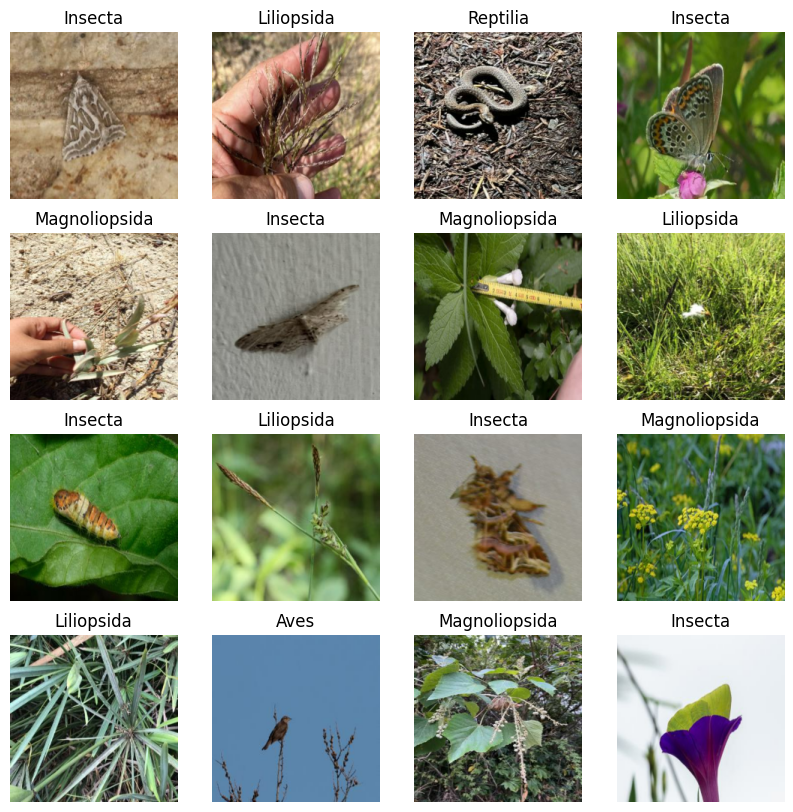

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_coarse.take(1):

    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        if fine_grain:
            plt.title(fine_names[labels[i]])
        else:
            plt.title(coarse_names[labels[i]])
        plt.axis("off")
plt.show()

The plot below show the count of each class in the training set.

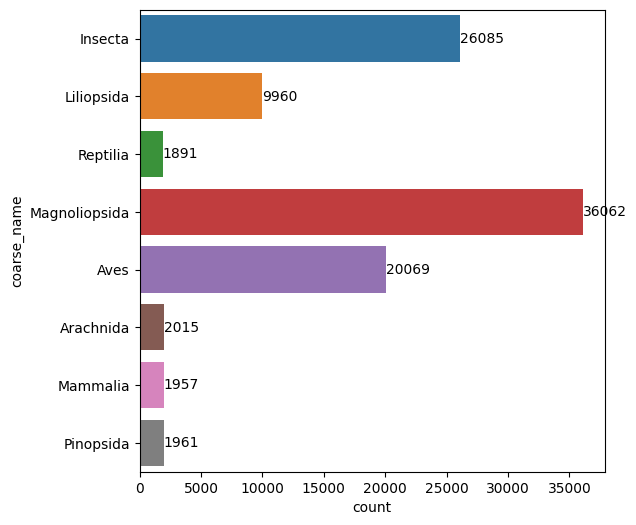

In [ ]:
# Set the figure size
plt.figure(figsize=(6, 6))

# Create a countplot using seaborn library, specifying the DataFrame and the column to count ('coarse_name')
ax = sns.countplot(data=df, y='coarse_name')

# Add labels to the bars indicating the count of each category
ax.bar_label(ax.containers[0])

# Display the plot
plt.show()


The class distribution in the training set is imbalanced, with varying numbers of samples for each coarse name. The majority class is Magnoliopsida with the highest number of samples, followed by Insecta and Aves. On the other hand, Arachnida, Pinopsida, Mammalia, and Reptilia have relatively fewer samples compared to the majority classes.

### Validation set

With the same approach as above, we will take a look at the validation set

In [20]:
val_df = pd.read_csv(root / "val.csv")
val_df['coarse_name'] = df['coarse'].map(dict(zip(list(range(8)), coarse_names)))
val_df['fine_name'] = df['fine'].map(dict(zip(list(range(50)), fine_names)))
val_df.head()

filename  coarse  fine    coarse_name   
0  4b8ce4a2d0a13de41940a350bc20a4ee6fe56f80.jpg       4    39        Insecta  \
1  c0260202167eab86fb176346afce166d4738ece1.jpg       4    34     Liliopsida   
2  4cf01a97732947c2313575449cdd3782b2ceb5e7.jpg       7    21       Reptilia   
3  9b478b50b49f3844b1cf1f3fea5d46b92bc0695c.jpg       4    29        Insecta   
4  f82c79a511c8da0eb51cffd41846e35b5d4aee7c.jpg       5    23  Magnoliopsida   

        fine_name  
0     Geometridae  
1         Poaceae  
2      Colubridae  
3      Lycaenidae  
4  Plantaginaceae

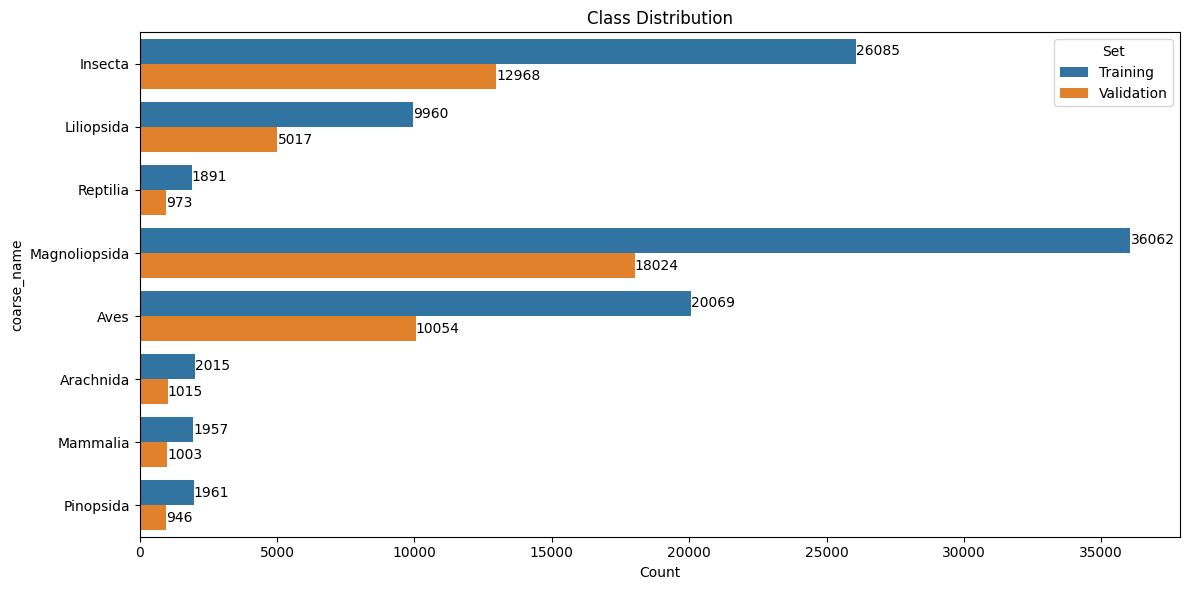

In [ ]:
plt.figure(figsize=(12, 6))

# Add a 'Set' column to the dataframes to differentiate between training and validation sets
df['Set'] = 'Training'
val_df['Set'] = 'Validation'

# Combine the training and validation dataframes
combined_df = pd.concat([df, val_df])

# Plot the class distribution
ax = sns.countplot(data=combined_df, y='coarse_name', hue='Set')
for label in ax.containers:
    ax.bar_label(label)
plt.title('Class Distribution')
plt.xlabel('Count')
plt.legend(title='Set')

plt.tight_layout()
plt.show()


The distribution of class labels in the validation set follows a similar trend as the training set, indicating that the validation set is representative of the overall dataset.

## Fine-grained

### Training set

We take a look again at the first 16 intances from the training set, with fine-grained label

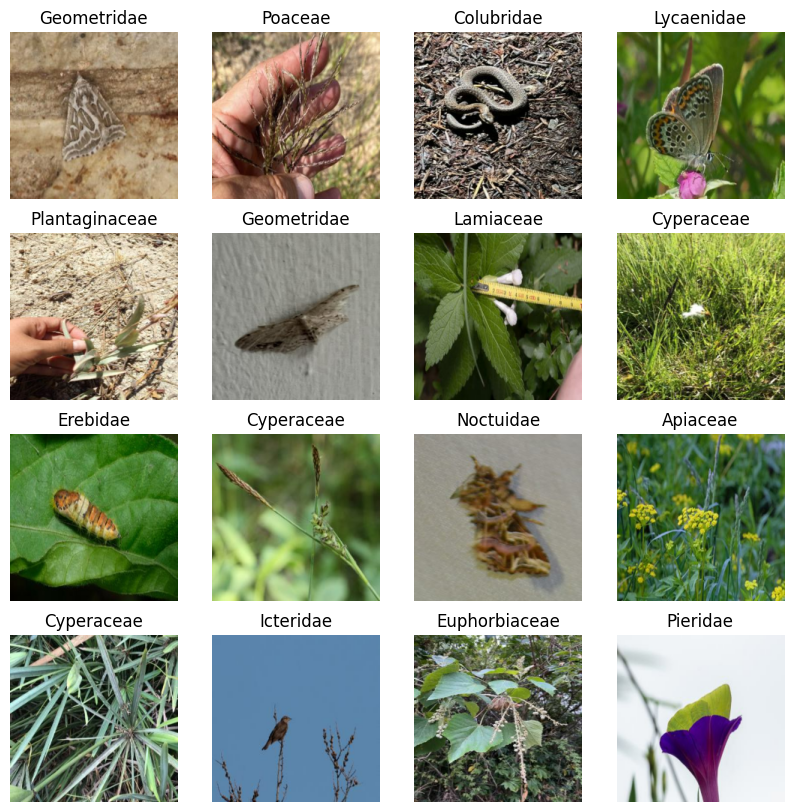

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds_fine.take(1):

    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(fine_names[labels[i]])
        plt.axis("off")
plt.show()

The plot below show the count of each class in the training set.

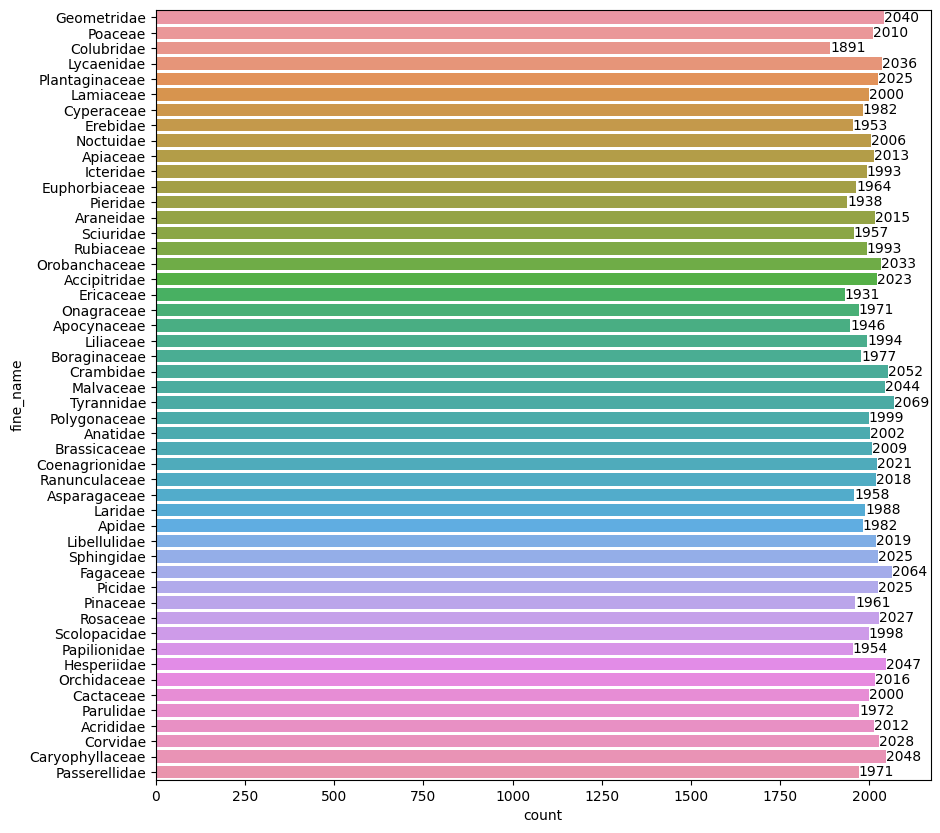

In [17]:
plt.figure(figsize=(10, 10))
ax = sns.countplot(data=df, y='fine_name')
ax.bar_label(ax.containers[0])
plt.show()


The class distribution seems relatively balanced, with only a slight variation in the number of samples across classes. In the next plot, we will present the class distribution in the validation dataset.

### Validation Set

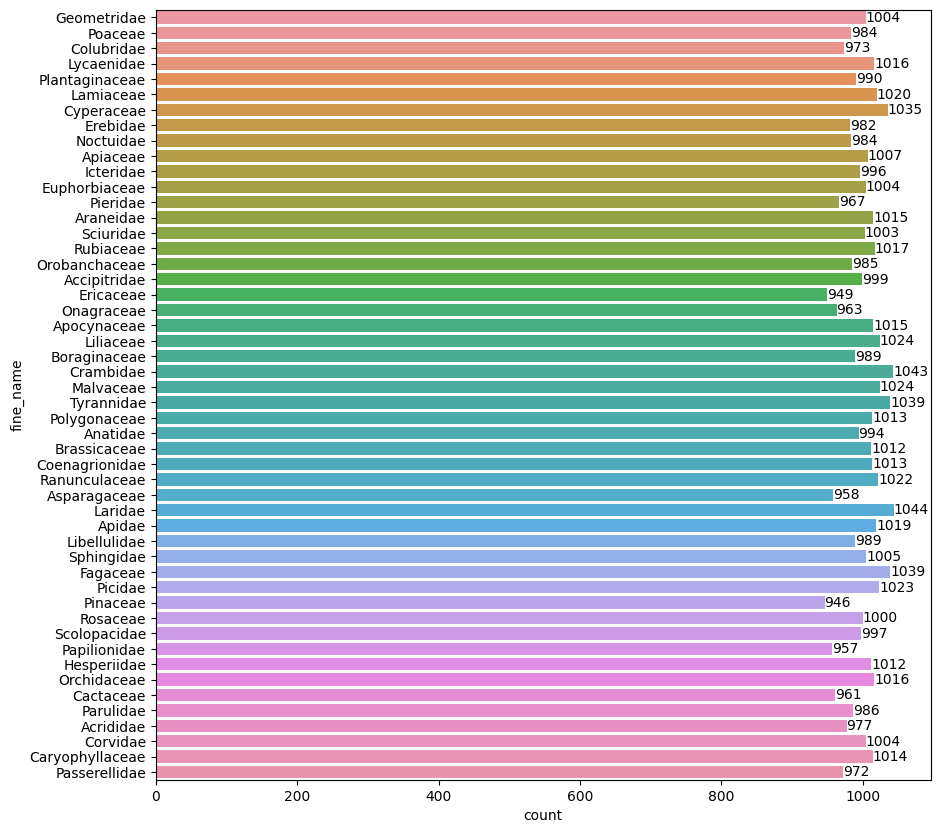

In [21]:
plt.figure(figsize=(10, 10))
ax = sns.countplot(data=val_df, y='fine_name')
ax.bar_label(ax.containers[0])
plt.show()


The distribution of class labels in the validation set follows a similar trend as the training set, indicating that the validation set is representative of the overall dataset.

#  Conventional Machine Model

## Coarse-grained

The final model that produced the best-performing predictions for the Kaggle submission (accuracy 47.34% on the public test set) was an Random Forest Classifier with fine-tuned parameters by GridSearch.

In [116]:
from sklearn.ensemble import RandomForestClassifier
rnd_coarse = RandomForestClassifier(
    class_weight=class_weights, bootstrap=False, max_depth=100, n_estimators=325)
rnd_coarse.fit(X_train_coarse, Y_train_coarse)


RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.6290890790135883,
                                     1: 6.793478260869565, 2: 7.142857142857143,
                                     3: 5.63063063063063,
                                     4: 0.34473248758963043,
                                     5: 0.47728140511645667,
                                     6: 1.2388503468780971,
                                     7: 7.022471910112359},
                       max_depth=100, n_estimators=325)

In [194]:
rnd_coarse.score(X_val_coarse, Y_val_coarse)

0.4648

## Notes on the Conventional Coarse Model

Before getting the final model for this part, the next actions were done

### Prepare the data

In [47]:
# making data for coarse label
X_train_coarse, Y_train_coarse = create_dataset_sklearn('train', fine_grained=False)
X_val_coarse, Y_val_coarse = create_dataset_sklearn('val', fine_grained=False)

In [193]:
X_test_coarse, _ = create_dataset_sklearn('privtest_coarse/privtest', fine_grained=False, percent=1)

In [48]:
print('Shape of X train:', X_train_coarse.shape)
print('Shape of X val:', X_val_coarse.shape)


Shape of X train: (10000, 2304)
Shape of X val: (5000, 2304)


The training coarse set contains 10000 images while the validation coarse set contains 5000 images.

The data is shown below

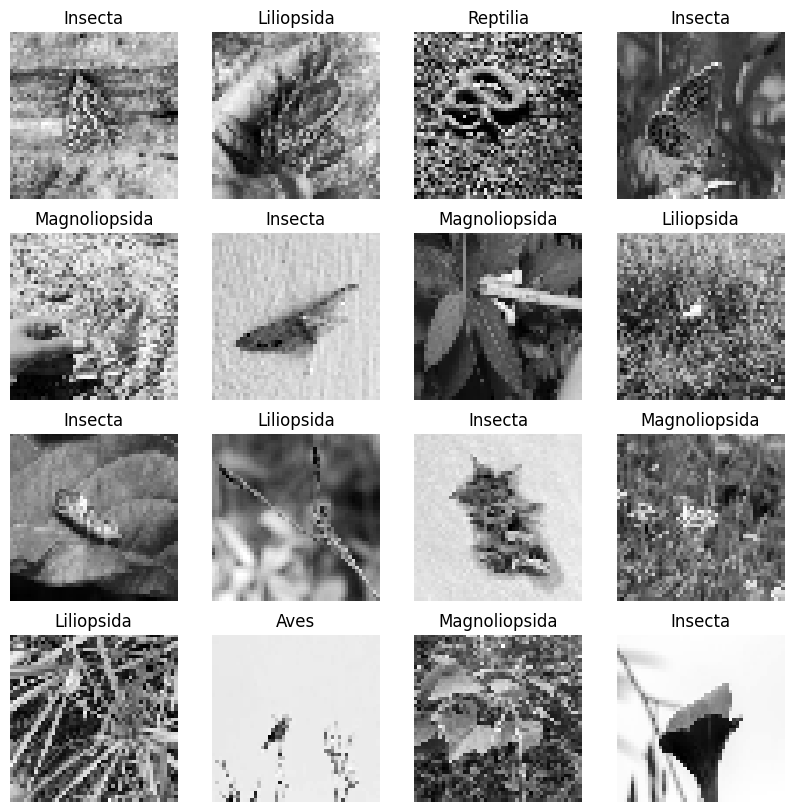

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X[i].reshape(48, 48), cmap='gray')
    if fine_grain:
        plt.title(fine_names[Y[i]])
    else:
        plt.title(coarse_names[Y[i]])
    plt.axis("off")
plt.show()


We tried Principal Component Analysis (PCA) to reduce dimension, but in doing so reduce much variations in the image itself. So we decided not to use PCA on the given dataset. 

Since the dataset is unbalanced, we can adjust the class weights during training. By assigning higher weights to underrepresented classes, we can encourage the model to pay more attention to these classes and reduce bias.

In [56]:
from sklearn.utils.class_weight import compute_class_weight

coarse_class_weights = dict(zip(np.unique(Y_train_coarse), compute_class_weight(class_weight="balanced",
                                                            classes=np.unique(
                                                                Y_train_coarse),
                                                            y=Y_train_coarse)))

In [62]:
print('Coarse class weights:')
for i in class_weights.keys():
    print(coarse_names[i], '\t',class_weights.get(i))

Coarse class weights:
Aves 	 0.6290890790135883
Reptilia 	 6.793478260869565
Mammalia 	 7.142857142857143
Arachnida 	 5.63063063063063
Magnoliopsida 	 0.34473248758963043
Insecta 	 0.47728140511645667
Liliopsida 	 1.2388503468780971
Pinopsida 	 7.022471910112359


### Train the Classifier  

We start by examining some potential model performance. Since this is a classification task, we will first try out some Classifiers.

We performs 5 splits for cross-validation with SGDClassifier, DecisionTreeClassifier, KNeighborsClassifier, GaussianNB and SVC and compare their performance in the next plot.

In [72]:
# perform cross validation and compute accuracy
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

random_seed = 42
# prepare models
coarse_models = []
coarse_models.append(('SGDClassifier', SGDClassifier(class_weight = class_weights)))
coarse_models.append(('KNeighborsClassifier', KNeighborsClassifier()))
coarse_models.append(('DecisionTreeClassifier', DecisionTreeClassifier(class_weight = class_weights)))
coarse_models.append(('GaussianNB', GaussianNB()))
coarse_models.append(('SVM', SVC(class_weight = class_weights)))
# evaluate each model in turn
coarse_results = []
coarse_model_names = []
scoring = 'accuracy'
for name, model in coarse_models:
    kfold = model_selection.KFold(n_splits=5, random_state=random_seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train_coarse, Y_train_coarse, cv=kfold, scoring=scoring)
    coarse_results.append(cv_results)
    coarse_model_names.append(name)
    msg = "%s: Mean Accuracy = %f (SD = %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

SGDClassifier: Mean Accuracy = 0.251800 (SD = 0.024390)
KNeighborsClassifier: Mean Accuracy = 0.233500 (SD = 0.002983)
DecisionTreeClassifier: Mean Accuracy = 0.284700 (SD = 0.006022)
GaussianNB: Mean Accuracy = 0.229800 (SD = 0.004781)
SVM: Mean Accuracy = 0.387900 (SD = 0.011914)


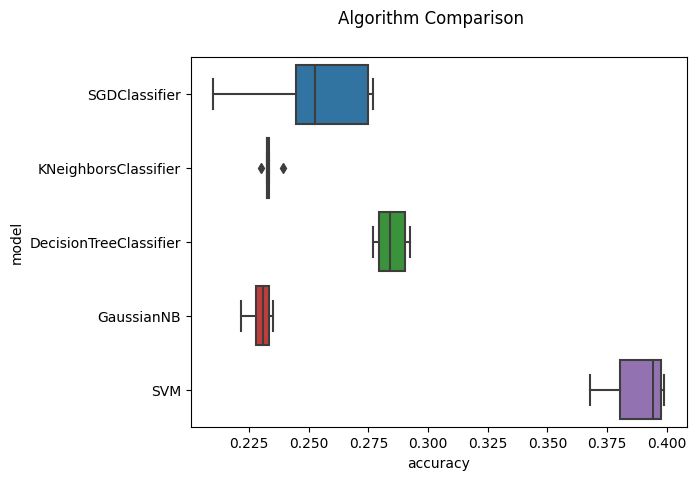

In [75]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.boxplot(coarse_results, orient="h")
ax.set_yticklabels(coarse_model_names)
ax.set_xlabel(scoring)
ax.set_ylabel('model')
plt.show()

Considering both mean accuracy and standard deviation, it appears that the SVM classifier has the highest mean accuracy and relatively low standard deviation compared to the other models. This suggests that the SVM model performs consistently well across different cross-validation folds and is the most promising among the evaluated classifiers.

Since we have already built a few predictors, let combine them to an even better predictor. We will build a RandomForestClassifier, an ExtraTreesClassifier, a VotingClassifier and a Stacking Classifier and evaluate their performance

In [178]:
from sklearn.ensemble import RandomForestClassifier
# fit an random forest classifier
rnd_coarse = RandomForestClassifier(class_weight = class_weights)
rnd_coarse.fit(X_train_coarse, Y_train_coarse)

RandomForestClassifier(class_weight={0: 0.6290890790135883,
                                     1: 6.793478260869565, 2: 7.142857142857143,
                                     3: 5.63063063063063,
                                     4: 0.34473248758963043,
                                     5: 0.47728140511645667,
                                     6: 1.2388503468780971,
                                     7: 7.022471910112359})

In [65]:
from sklearn.ensemble import ExtraTreesClassifier
# fit an extra tree classifier
extra_trees_coarse = ExtraTreesClassifier(class_weight = class_weights)
extra_trees_coarse.fit(X_train_coarse, Y_train_coarse)

ExtraTreesClassifier(class_weight={0: 0.6290890790135883, 1: 6.793478260869565,
                                   2: 7.142857142857143, 3: 5.63063063063063,
                                   4: 0.34473248758963043,
                                   5: 0.47728140511645667,
                                   6: 1.2388503468780971,
                                   7: 7.022471910112359})

In [77]:
from sklearn.ensemble import VotingClassifier, StackingClassifier


# create a voting classifier
voting_coarse = VotingClassifier(
    estimators=[
        ('rf', rnd_coarse),
        ('svc', SVC(class_weight = class_weights, probability=True)),
        ('ext', extra_trees_coarse)
    ], voting = 'soft'
)

voting_coarse.fit(X_train_coarse, Y_train_coarse)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={0: 0.6290890790135883,
                                                                   1: 6.793478260869565,
                                                                   2: 7.142857142857143,
                                                                   3: 5.63063063063063,
                                                                   4: 0.34473248758963043,
                                                                   5: 0.47728140511645667,
                                                                   6: 1.2388503468780971,
                                                                   7: 7.022471910112359})),
                             ('svc',
                              SVC(class_weight={0: 0.6290890790135883,
                                                1: 6.793478260869565,
                                                2: 7.142857142857143,
                                                3: 5.63063063063063,
                                                4: 0.34473248758963043,
                                                5: 0.47728140511645667,
                                                6: 1.2388503468780971,
                                                7: 7.022471910112359},
                                  probability=True)),
                             ('ext',
                              ExtraTreesClassifier(class_weight={0: 0.6290890790135883,
                                                                 1: 6.793478260869565,
                                                                 2: 7.142857142857143,
                                                                 3: 5.63063063063063,
                                                                 4: 0.34473248758963043,
                                                                 5: 0.47728140511645667,
                                                                 6: 1.2388503468780971,
                                                                 7: 7.022471910112359}))],
                 voting='soft')

In [80]:
# create a stacking classifier
stacking_coarse = StackingClassifier(
    estimators=[
        ('ext', extra_trees_coarse),
        ('rf', rnd_coarse),
    ],
    final_estimator=RandomForestClassifier(random_state=43)
)
stacking_coarse.fit(X_train_coarse, Y_train_coarse)

StackingClassifier(estimators=[('ext',
                                ExtraTreesClassifier(class_weight={0: 0.6290890790135883,
                                                                   1: 6.793478260869565,
                                                                   2: 7.142857142857143,
                                                                   3: 5.63063063063063,
                                                                   4: 0.34473248758963043,
                                                                   5: 0.47728140511645667,
                                                                   6: 1.2388503468780971,
                                                                   7: 7.022471910112359})),
                               ('rf',
                                RandomForestClassifier(class_weight={0: 0.6290890790135883,
                                                                     1: 6.793478260869565,
                                                                     2: 7.142857142857143,
                                                                     3: 5.63063063063063,
                                                                     4: 0.34473248758963043,
                                                                     5: 0.47728140511645667,
                                                                     6: 1.2388503468780971,
                                                                     7: 7.022471910112359}))],
                   final_estimator=RandomForestClassifier(random_state=43))

We use cross-validation to compare each ensemble model performance on the validation dataset. 

The output below shows mean and SD of accuracy when we evaluate the model cross validation scoree with 5 folds. 

The boxplot visualize their performance in comparision

In [82]:
coarse_ensembles = []
coarse_ensembles.append(('RandomForestClassifier', rnd_coarse))
coarse_ensembles.append(('ExtraTreesClassifier', extra_trees_coarse))
coarse_ensembles.append(('VotingClassifier', voting_coarse))
coarse_ensembles.append(('StackingClassifier', stacking_coarse))
coarse_ensemble_results = []
coarse_ensemble_names = []
for name, model in coarse_ensembles:
    cv_results = model_selection.cross_val_score(model, X_val_coarse, Y_val_coarse, cv=5, scoring=scoring)
    coarse_ensemble_results.append(cv_results)
    coarse_ensemble_names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



RandomForestClassifier: 0.459600 (0.006681)
ExtraTreesClassifier: 0.456200 (0.006794)
VotingClassifier: 0.456600 (0.008237)
StackingClassifier: 0.455600 (0.010874)


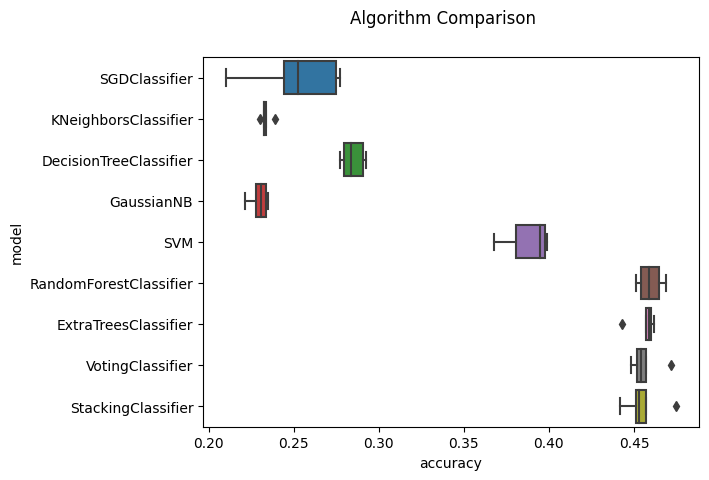

In [122]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.boxplot(coarse_results + coarse_ensemble_results , orient="h")
ax.set_yticklabels(coarse_model_names + coarse_ensemble_names)
ax.set_xlabel(scoring)
ax.set_ylabel('model')
plt.show()

Based on both mean accuracy and standard deviation, the RandomForestClassifier stands out as the top-performing model with the highest mean accuracy and relatively low variability in performance. 
The ExtraTreesClassifier also performs well and has a similar mean accuracy but slightly higher variability compared to the RandomForestClassifier.

Next, we will finetune the best performing model, which is the RandomForestClassifier, to see if we can improve the accuracy.

### Fine Tune the Top performing Model

We use GridSearchCV to find the best hyperparameters for a random forest classifier using a predefined parameter grid.



In [96]:
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
max_depth.append(None)
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'n_estimators': n_estimators
}
pprint(param_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 55, 100, None],
 'n_estimators': [100, 550, 1000]}


In [92]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator = rnd_coarse, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_coarse, Y_train_coarse)

The best parameter for the random forest are

In [106]:
best_coarse_conv = grid_search.best_estimator_
grid_search.best_params_

{'bootstrap': False, 'max_depth': 100, 'n_estimators': 325}

We can see the result of finetunning below, which shows best 5 parameter combination for random forest.

In [109]:
coarse_cv_results = pd.DataFrame(grid_search.cv_results_)
desired_columns = ['mean_score_time', 'mean_test_score', 'rank_test_score', 'param_bootstrap', 'param_max_depth', 'param_n_estimators']
desired_results = coarse_cv_results.sort_values(by='rank_test_score').head()[desired_columns]
desired_results

mean_score_time  mean_test_score  rank_test_score param_bootstrap   
51         0.422148         0.466399                1           False  \
43         1.080059         0.466200                2           False   
46         0.420683         0.465500                3           False   
48         1.043421         0.465299                4           False   
36         0.416282         0.464900                5           False   

   param_max_depth param_n_estimators  
51             100                325  
43              55                775  
46              77                325  
48              77                775  
36              32                325

We evaluate our improvement compare to the base random forest model

In [179]:
base_accuracy = round(rnd_coarse.score(X_val_coarse, Y_val_coarse) * 100,2)
print('Base model performance: \t Accuracy = ', base_accuracy, '%')

best_accuracy = round(best_coarse_conv.score(X_val_coarse, Y_val_coarse) * 100,2)
print('Fine tuned model performance: \t Accuracy = ', best_accuracy, '%')    


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))


Base model performance: 	 Accuracy =  46.48 %
Fine tuned model performance: 	 Accuracy =  47.46 %
Improvement of 2.11%.


The fine tune model got an increase accuracy of 2% compare to the initial Random Forest Classifier, which is not too impressive, but still an improvement.

The final accuracy is around 47%, which is quite low. However, given the fact that we just only use 10% of the whole training data, it is reasonable that we can improve this score later on. However, due to limiting computational power, training with the full dataset could be done in future time. We conclude our final model here and make the prediction for Kaggle.

In [198]:
y_pred = best_coarse_conv.predict(X_test_coarse)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "predictions/46864660-conv-coarse.csv"  
test_csv.to_csv(pred_file, index=False)


## Fine-grained

The final model that produced the best-performing predictions for the Kaggle submission (accuracy 6.5% on the public test set) was an Extra-Trees Classifier with fine-tuned parameters by GridSearch.

In [181]:
rnd_fine = ExtraTreesClassifier(max_depth= 55, n_estimators = 1000)
rnd_fine.fit(X_train_fine, Y_train_fine)


ExtraTreesClassifier(max_depth=55, n_estimators=1000)

In [182]:
rnd_fine.score(X_val_fine, Y_val_fine)

0.068

## Notes on the Conventional Fine Model

Before getting the final model for this part, the next actions were done

### Prepare the data

In [139]:
# making data for fine label
X_train_fine, Y_train_fine = create_dataset_sklearn('train', fine_grained=True)
X_val_fine, Y_val_fine = create_dataset_sklearn('val', fine_grained=True)

In [124]:
X_test_fine, _ = create_dataset_sklearn('test', fine_grained=True, percent=1)

In [132]:
print('Shape of X train:', X_train_fine.shape)
print('Shape of X val:', X_val_fine.shape)


Shape of X train: (10000, 2304)
Shape of X val: (5000, 2304)


The training fine set contains 10000 images while the validation coarse set contains 5000 images of 50 classes.

Here is some image and their fine name label

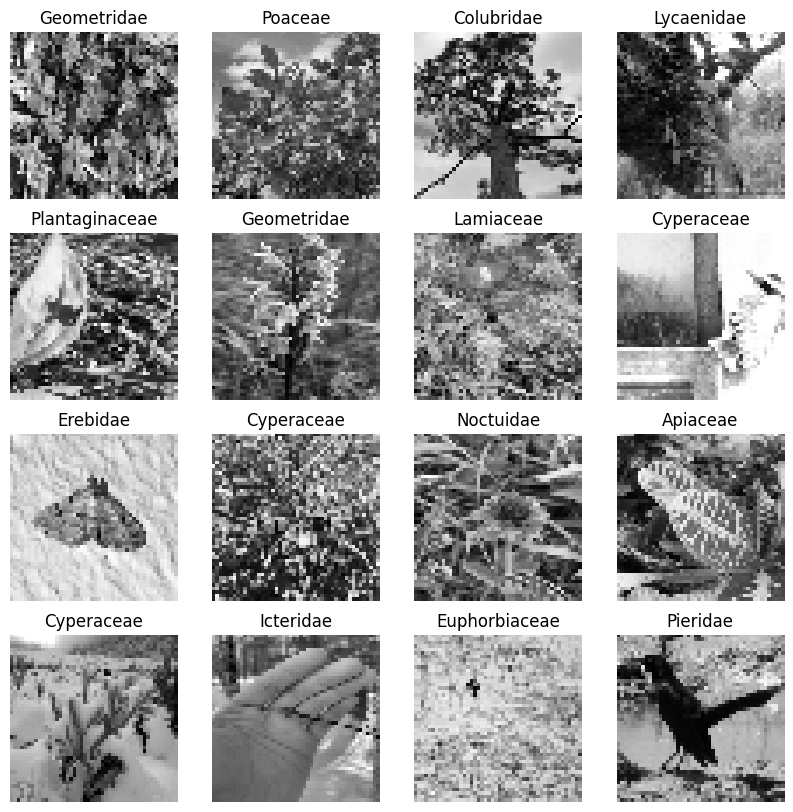

In [129]:
plt.figure(figsize=(10, 10))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(X_val_fine[i].reshape(48, 48), cmap='gray')
    plt.title(fine_names[Y_train_fine[i]])
    plt.axis("off")
plt.show()


### Train the classifier

Since this is somewhat a similar task as with the Coarse version, we will start by evaluate the performance of the ensemble classifiers without looking at the single classifiers, since we observed that ensemble classifier generally perform better in this task. Due to computational limitation, this section only a examine RandomForestClassifier and ExtraTreesClassifier. 

We do the same as in Coarse part, to compare the two model performances.

In [131]:
# prepare models
fine_models = []
fine_models.append(('ExtraTreesClassifier', ExtraTreesClassifier()))
fine_models.append(('RandomForestClassifier', RandomForestClassifier()))
# evaluate each model in turn
fine_results = []
fine_model_names = []
for name, model in fine_models:
    kfold = model_selection.KFold(n_splits=5, random_state=random_seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, X_train_fine, Y_train_fine, cv=kfold, scoring=scoring)
    fine_results.append(cv_results)
    fine_model_names.append(name)
    msg = "%s: Mean Accuracy = %f (SD = %f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ExtraTreesClassifier: Mean Accuracy = 0.053400 (SD = 0.001960)
RandomForestClassifier: Mean Accuracy = 0.052500 (SD = 0.004796)


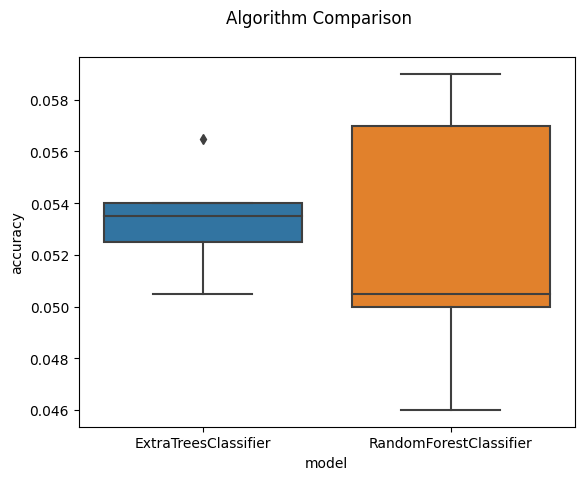

In [136]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
sns.boxplot(fine_results)
ax.set_xticklabels(fine_model_names)
ax.set_xlabel('model')
ax.set_ylabel(scoring)
plt.show()

In term of average accuracy, ExtraTreesClassifier seems to be the better performing model. In the next part, we try to fine tune it to see if we can improve the overall accuracy.

### Fine tune the better model

We use GridSearchCV to find the best hyperparameters for a random forest classifier using a predefined parameter grid.

In [140]:
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 3)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 3)]
max_depth.append(None)
# Create the random grid
param_grid = {
    'max_depth': max_depth,
    'n_estimators': n_estimators
}
pprint(param_grid)

{'max_depth': [10, 55, 100, None], 'n_estimators': [100, 550, 1000]}


In [162]:
from sklearn.model_selection import GridSearchCV
rnd_fine = ExtraTreesClassifier()
grid_search = GridSearchCV(estimator = rnd_fine, param_grid = param_grid, 
                          cv = 3, verbose = 2)
grid_search.fit(X_train_fine, Y_train_fine)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.5s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.5s
[CV] END .....................max_depth=10, n_estimators=550; total time=  13.3s
[CV] END .....................max_depth=10, n_estimators=550; total time=  13.4s
[CV] END .....................max_depth=10, n_estimators=550; total time=  13.4s
[CV] END ....................max_depth=10, n_estimators=1000; total time=  24.2s
[CV] END ....................max_depth=10, n_estimators=1000; total time=  24.2s
[CV] END ....................max_depth=10, n_estimators=1000; total time=  24.3s
[CV] END .....................max_depth=55, n_estimators=100; total time=   6.1s
[CV] END .....................max_depth=55, n_estimators=100; total time=   6.0s
[CV] END .....................max_depth=55, n_es

GridSearchCV(cv=3, estimator=ExtraTreesClassifier(),
             param_grid={'max_depth': [10, 55, 100, None],
                         'n_estimators': [100, 550, 1000]},
             verbose=2)

In [163]:
best_fine_conv = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 55, 'n_estimators': 1000}

These are the best test score based on the results of GridSearch

In [165]:
fine_cv_results = pd.DataFrame(grid_search.cv_results_)
desired_columns = ['mean_score_time', 'mean_test_score', 'rank_test_score', 'param_max_depth', 'param_n_estimators']
desired_results = fine_cv_results.sort_values(by='rank_test_score').head()[desired_columns]
desired_results

mean_score_time  mean_test_score  rank_test_score param_max_depth   
5          2.448227           0.0652                1              55  \
11         2.488779           0.0638                2            None   
8          2.552674           0.0631                3             100   
7          1.245415           0.0620                4             100   
10         1.276809           0.0607                5            None   

   param_n_estimators  
5                1000  
11               1000  
8                1000  
7                 550  
10                550

Looking at the next plot, it seems like mean_test_score increase with the number of estimator and the max depth of the tree in the ExtraTreesClassifier.

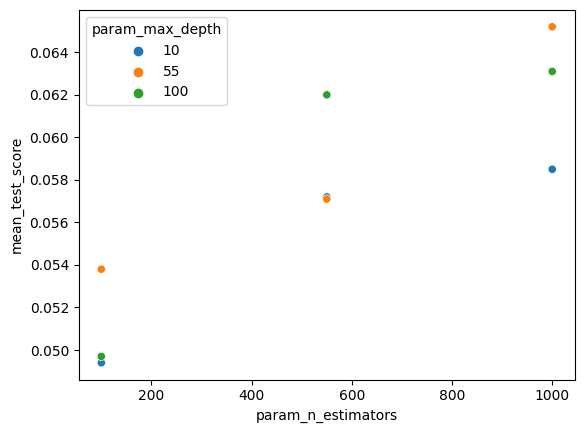

In [180]:
sns.scatterplot(data = fine_cv_results, x = 'param_n_estimators', y = 'mean_test_score', hue = 'param_max_depth')
plt.show()

We may perform further finetuning with larger number of estimators. But due to timeconstraint, we leave it for future work. Now, to evaluate the effect of finetuning, we compare the base model with the best model found.

In [174]:
base_accuracy = round(rnd_fine.score(X_val_fine, Y_val_fine) * 100,2)
print('Base model performance: \t Accuracy = ', base_accuracy, '%')

best_accuracy = round(best_fine_conv.score(X_val_fine, Y_val_fine) * 100,2)
print('Fine tuned model performance: \t Accuracy = ', best_accuracy,'%')    


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base model performance: 	 Accuracy =  5.28 %
Fine tuned model performance: 	 Accuracy =  6.92 %
Improvement of 31.06%.


We have an improvement of 31% compare to the original model. That seems really impressive. But due to the fact that our accuracy of both models is really low, this is a minor improvement. 

Since we only use 10% of the total training data, there is still a lot of rooms for improvement. For now, we conclude our work and make the prediction for Kaggle.

In [200]:
y_pred = best_fine_conv.predict(X_test_fine)
test_csv = pd.read_csv(root / f"privtest.csv")
test_csv.loc[:, "fine"] = y_pred
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "predictions/46864660-conv-fine.csv"  
test_csv.to_csv(pred_file, index=False)


# Deep Learning Model

## Coarse-grained

The final model that produced the best-performing predictions for the Kaggle submission was a fine tuned InceptionV3 model.  
We got an accuracy of **86.35%** on the public set, achieving the 5th position on the leaderboard. The accuracy with regard to the private test set is **86.8%**, ranking 8th on the leaderboard.

The following code create the dataset for tensorflow model

In [6]:
# define some parameter
batch_size = 64
img_size = 224
fine_grain = False
num_classes = 50 if fine_grain else 8


In [7]:
# create data set for coarse labels
train_ds_coarse = create_dataset_tf(
    'train', fine_grained=False, batch_size=batch_size, image_size=img_size)
val_ds_coarse = create_dataset_tf(
    'val', fine_grained=False, batch_size=batch_size,  image_size=img_size)
test_ds_coarse = create_dataset_tf(
    'test', fine_grained=False, batch_size=batch_size,  image_size=img_size)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



Use data augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.3, 0.3),
    tf.keras.layers.RandomRotation(factor=0.2),
])

We create our model using pretrained InceptionV3 model and compile

In [13]:
# create the base pre-trained model
base_model_coarse = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),)

# freeze the base model layer
for layer in base_model_coarse.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model_coarse(x)

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer
x = tf.keras.layers.Dropout(0.2)(x) 
# and a logistic layer
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# create the base pre-trained model
model_coarse = tf.keras.Model(inputs=inputs, outputs=predictions)
model_coarse.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                             

The final model after finetuning will have more trainable params as follow

In [368]:
model_coarse = tf.keras.saving.load_model("models/InceptionV3_coarse")

In [171]:
model_coarse.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 8)                 16392     
                                                                 
Total params: 21,819,176
Trainable params: 12,828,296
Non-trainable params: 8,990,880
_________________________________________

In [172]:
model_coarse.evaluate(val_ds_coarse)

782/782 [==============================] - 134s 170ms/step - loss: 0.4498 - accuracy: 0.8556


[0.44979482889175415, 0.8555600047111511]

## Notes on the Deep Learning Coarse Model

### Artificial Neural Network

In order to find a general model to predict the coarse class label through deep learning, we started trying with a simple neural network. This network consists of three dense layers with ReLU activation functions, followed by an output layer with a softmax activation function. It takes input images and aims to classify them into one of the eight classes represented by the output layer.

In [175]:
# create the model
nn_model_coarse = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[img_size, img_size, 3]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])


In [176]:
nn_model_coarse.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_4 (Dense)             (None, 300)               45158700  
                                                                 
 dense_5 (Dense)             (None, 100)               30100     
                                                                 
 dense_6 (Dense)             (None, 8)                 808       
                                                                 
Total params: 45,189,608
Trainable params: 45,189,608
Non-trainable params: 0
_________________________________________________________________


We compiled the NN using sparse_categorical_crossentropy as loss function, with Adam as the optimizer. We fit with 10 epochs.

In [182]:
# compile the model
nn_model_coarse.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])


In [183]:
history_cnn_coarse = cnn_model_coarse.fit(train_ds_coarse, epochs=10, validation_data=val_ds_coarse)


Epoch 1/10
1563/1563 [==============================] - 94s 60ms/step - loss: 3.8517 - accuracy: 0.3818 - val_loss: 1.6830 - val_accuracy: 0.3618
Epoch 2/10
1563/1563 [==============================] - 93s 59ms/step - loss: 1.5034 - accuracy: 0.4489 - val_loss: 1.4693 - val_accuracy: 0.4753
Epoch 3/10
1563/1563 [==============================] - 94s 60ms/step - loss: 1.4412 - accuracy: 0.4718 - val_loss: 1.3947 - val_accuracy: 0.4905
Epoch 4/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.3926 - accuracy: 0.4869 - val_loss: 1.3793 - val_accuracy: 0.4910
Epoch 5/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.3851 - accuracy: 0.4892 - val_loss: 1.4713 - val_accuracy: 0.4541
Epoch 6/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.3697 - accuracy: 0.4931 - val_loss: 1.3899 - val_accuracy: 0.4984
Epoch 7/10
1563/1563 [==============================] - 92s 59ms/step - loss: 1.3462 - accuracy: 0.5060 - val_loss: 1.3718 -

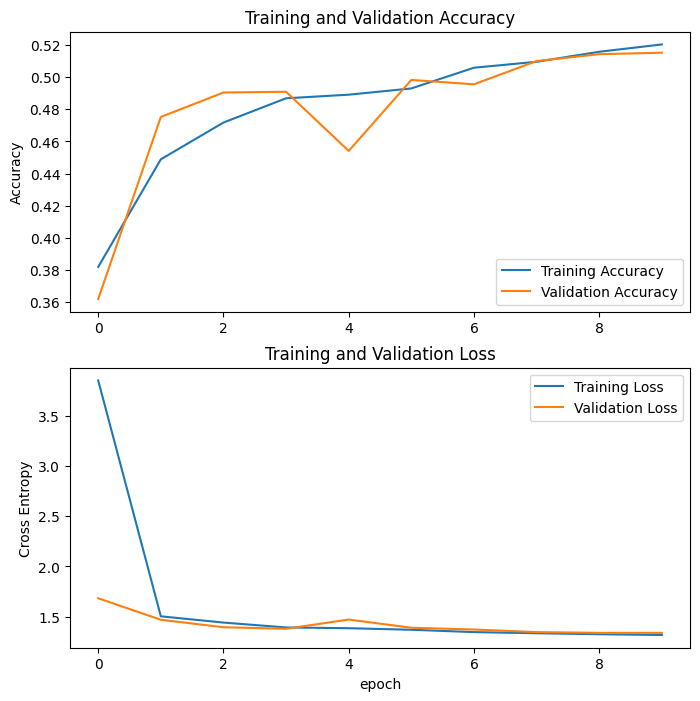

In [188]:
acc = history_cnn_coarse.history['accuracy']
val_acc = history_cnn_coarse.history['val_accuracy']

loss = history_cnn_coarse.history['loss']
val_loss = history_cnn_coarse.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After training the simple NN, we achieve a low accuracy of 0.5205 in the training set
and 0.5153 in the test set after 10 epochs. The learning curve flatten after 4-5 epochs suggest that the model having difficulty in learning the data. Therefore, we need a more appropriate model for image classification. In the next section, we try to build a simple convolutional network model to tackle the problem.

### Convolutional Neural Network

We will approach with a convolutional neural network. Here is the description of the network:

1. The network starts with a 2D convolutional layer (`DefaultConv2D`) with 64 filters and a kernel size of 7. This layer takes input images of shape `[img_size, img_size, 3]` and applies the ReLU activation function.

2. A max pooling layer (`MaxPool2D`) is added to downsample the spatial dimensions of the feature maps.

3. Two more `DefaultConv2D` layers with 128 filters each are added consecutively. These layers continue to extract more complex features from the input.

4. Another max pooling layer is applied to further reduce the spatial dimensions.

5. Two more `DefaultConv2D` layers with 256 filters each are added. These layers aim to capture higher-level features from the input.

6. Another max pooling layer is applied.

7. The feature maps are flattened into a 1D vector using the `Flatten` layer.

8. Two fully connected (dense) layers are added with 128 and 64 units, respectively. Each dense layer uses the ReLU activation function and the He normal initializer for the kernel weights.

9. Dropout layers with a dropout rate of 0.5 are included after each dense layer. Dropout helps prevent overfitting by randomly dropping out a fraction of the units during training.

10. The final dense layer consists of 8 units with the softmax activation function, representing the probabilities of the input image belonging to each of the 8 classes.

In [349]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")
conv_coarse = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[
                  img_size, img_size, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation="softmax")
])
conv_coarse.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_238 (Conv2D)         (None, 224, 224, 64)      9472      
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_239 (Conv2D)         (None, 112, 112, 128)     73856     
                                                                 
 conv2d_240 (Conv2D)         (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_241 (Conv2D)         (None, 56, 56, 256)     

In [350]:
conv_coarse.compile(loss="sparse_categorical_crossentropy",
                   optimizer="adam",
                   metrics=["accuracy"])

With the same setting as before, we fit the model for 20 epochs and observe the results

In [ ]:
history_conv_coarse = conv_coarse.fit(train_ds_coarse, epochs=20, validation_data=val_ds_coarse)

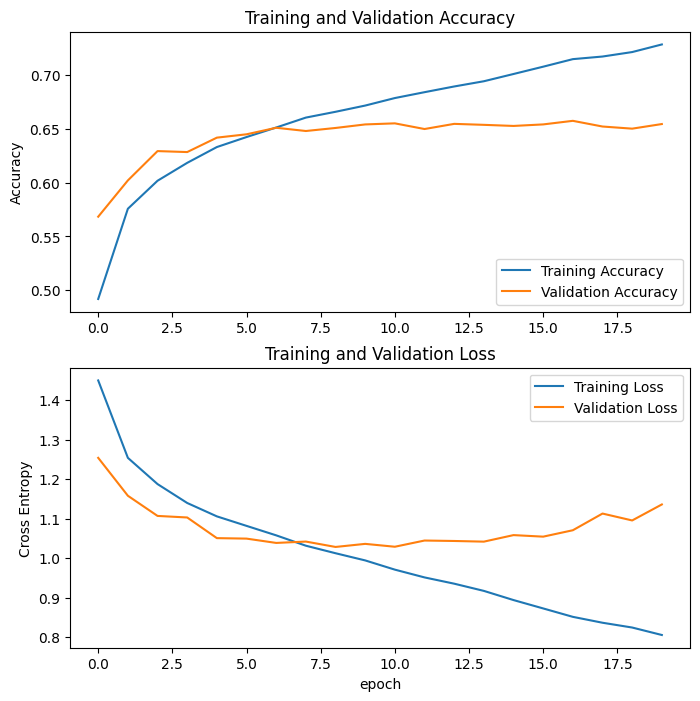

In [348]:
acc = history_conv_coarse.history['accuracy']
val_acc = history_conv_coarse.history['val_accuracy']

loss = history_conv_coarse.history['loss']
val_loss = history_conv_coarse.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


The Convolutional Neural Network shows much improvement compare to the first Neural Network model interm of both **training accuracy** (0.7282 compare to 0.5205 of the first model) and **validation accuracy**(0.6543 compare to 0.5153 of the first model). However, based on the history of model fitting, we can make the following observations:



1. Validation Accuracy: The validation accuracy shows a similar trend to the training accuracy, but it appears to flatten after a certain epoch. This flattening indicates that the model's performance on the validation data is not improving significantly beyond that point.

2. Validation Loss:  The increase in validation loss after around the 11th epoch suggests a potential overfitting issue or a deviation from the model's generalization performance

When the validation accuracy plateaus, it suggests that the model has reached its maximum potential in terms of learning from the available data. It may have already captured most of the patterns and information necessary for making predictions. At this point, further training iterations may not lead to substantial improvements in accuracy on the validation set.

In the next section, we will explore the potential of using transfer learning in Keras to tackle this classification problem.

### Using Pretrained Models from Keras

We aim to improve our model generalize performance. One way to do that is through data augmentation.

When dealing with imbalanced datasets, data augmentation can be a useful technique to address the class imbalance and improve the performance of the model. It helps to artificially increase the size of the minority class, making the dataset more balanced and providing the model with a more diverse set of examples to learn from. 

We applied augmentation that did not lose the sense of the images: horizontal and vertical flip, zoom, small rotation.

In [211]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),
    tf.keras.layers.RandomZoom(0.3, 0.3),
    tf.keras.layers.RandomRotation(factor=0.2),
])

We show some image after augmentation as below

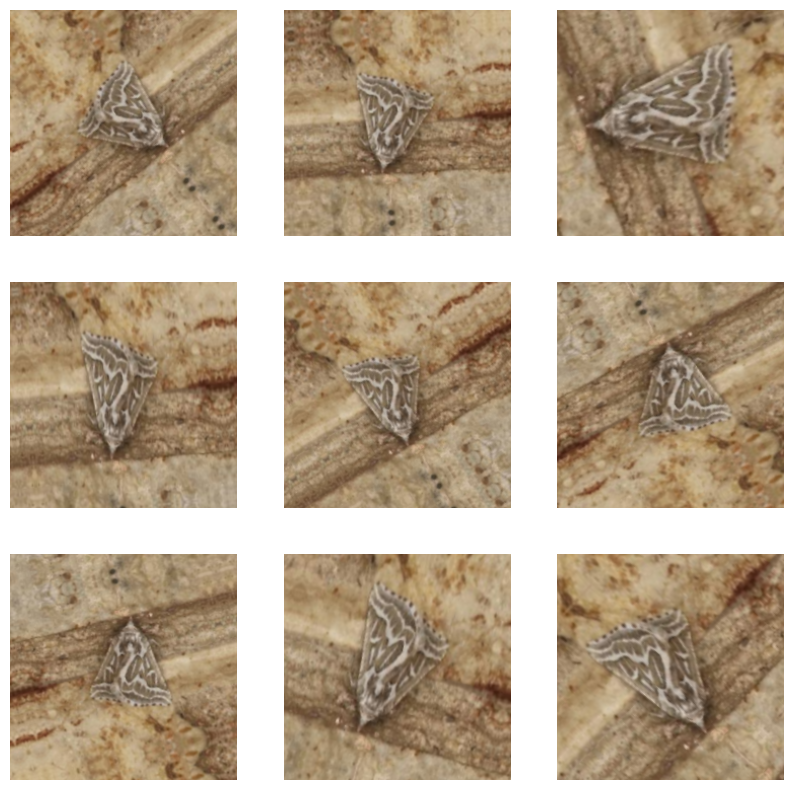

In [214]:
for image, _ in train_ds_coarse.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

The model we are using is a fine-tuning approach using the InceptionV3 pre-trained model as a base. Here is a breakdown of its components and architecture:

1. Base Pre-trained Model: The base model used is InceptionV3, which is a deep convolutional neural network pre-trained on the ImageNet dataset.

2. Freezing Base Model Layers: To leverage the pre-trained weights and avoid overfitting, all layers of the base model are set to be non-trainable. This freezing prevents the weights from being updated during training.

3. Input and Data Augmentation: The model takes input images with dimensions (img_size, img_size, 3). Data augmentation, denoted as "data_augmentation," is applied as described above.

4. Base Model Integration: The output of the data augmentation layer is passed through the base model (InceptionV3) to obtain the feature representations. This step allows the model to benefit from the learned hierarchical features extracted by InceptionV3.

5. Global Average Pooling: A global average pooling layer is added to the model. This layer reduces the spatial dimensions of the feature maps to a single vector by taking the average of each channel. It helps in reducing the model's parameters and capturing the most important information from the feature maps.

6. Dropout Regularization: A dropout layer with a rate of 0.2 is inserted after the global average pooling layer, which helps prevent overfitting and improves generalization.

7. Logistic Layer: The output of the dropout layer is connected to a fully connected layer with a softmax activation function. This layer serves as the final prediction layer, producing the probabilities for each class in the classification task.

In [ ]:
# create the base pre-trained model
base_model_coarse = tf.keras.applications.InceptionV3(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),)

# freeze the base model layer
for layer in base_model_coarse.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model_coarse(x)

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# add a dropout layer
x = tf.keras.layers.Dropout(0.2)(x) 
# and a logistic layer
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# create the base pre-trained model
model_coarse = tf.keras.Model(inputs=inputs, outputs=predictions)

We can compile the model and start training for a few epochs to fit the predictions layer:

In [ ]:
# train the model on the new data for a few epochs
history_coarse = model_coarse.fit(train_ds_coarse, epochs=5,
                        validation_data=val_ds_coarse)

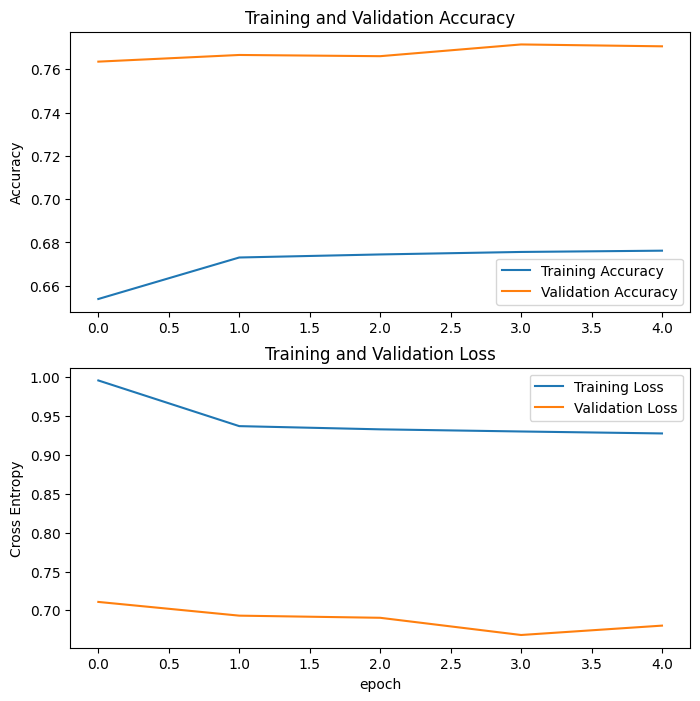

In [354]:
acc = history_coarse.history['accuracy']
val_acc = history_coarse.history['val_accuracy']

loss = history_coarse.history['loss']
val_loss = history_coarse.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

After just a few epochs, we already have a major increase in validation accuracy over the simple CNN. The validation accuracy of the CNN is 0.6543 after 20 epochs, while the validation accuracy of the new transfer model is 0.7706.

We can improve further by fine tuning the model, unfreezing some layers from the base model and train the whole model with low learning rate for some more epochs. Other than that, we will apply some callbacks during the training process

In [353]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in base_model_coarse.layers[:249]:
    layer.trainable = False
for layer in base_model_coarse.layers[249:]:
    layer.trainable = True
model_coarse.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_23 (Dropout)        (None, 2048)              0         
                                                                 
 dense_40 (Dense)            (None, 8)                 16392     
                                                           

In [ ]:
model_coarse.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [157]:
# Define the learning rate scheduler callback
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=3,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,            # Print a message when the learning rate is reduced
    min_lr=1e-6           # Lower bound on the learning rate
)
# Define the early stopping callback
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

1. With the ReduceLROnPlateau callback, the learning rate will be automatically reduced when the monitored metric (validation loss) stops improving for a certain number of epochs. This allows the model to fine-tune its learning rate and potentially improve performance
2. The EarlyStopping callback allows us to automatically stop the training process if the monitored metric (validation loss) does not improve for a specified number of epochs, helping to prevent overfitting and saving training time

In [ ]:
# fit the model for 10 more epochs
history_coarse_finetune = model_coarse.fit(train_ds_coarse, epochs=10, validation_data=val_ds_coarse, callbacks=[
                        early_stopping_cb, lr_scheduler])



In [ ]:
acc += history_coarse_finetune.history['accuracy']
val_acc += history_coarse_finetune.history['val_accuracy']

loss += history_coarse_finetune.history['loss']
val_loss += history_coarse_finetune.history['val_loss']

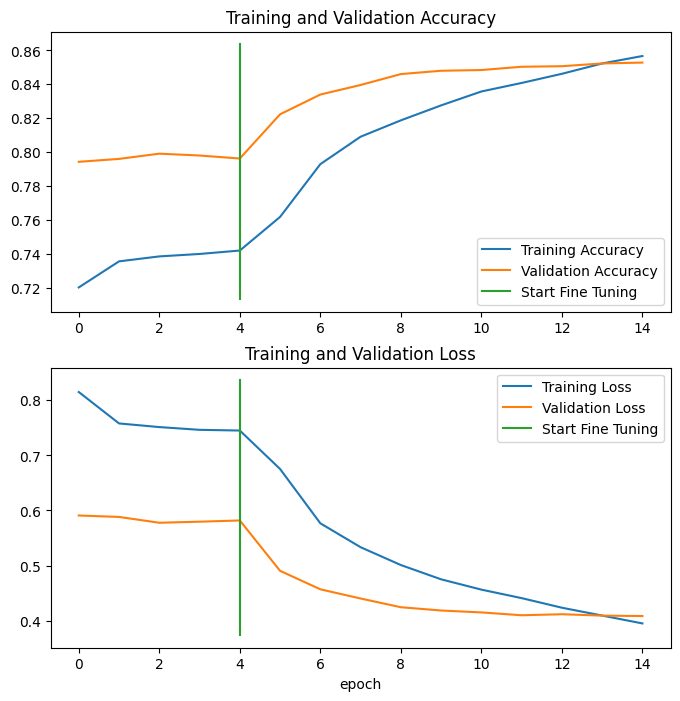

In [363]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([5-1,5-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([5-1,5-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

We can see that the learning curve change significantly when we start fine tunning. The model are able to fit the training data quicker, and the validation accuracy also increase by a large portion. The validation accuracy continue to improve until flatten at around 0.85 while the training accuracy continue to increase.

We could try to unfreeze the whole base model, and train 20 more epochs. The result is shown below:

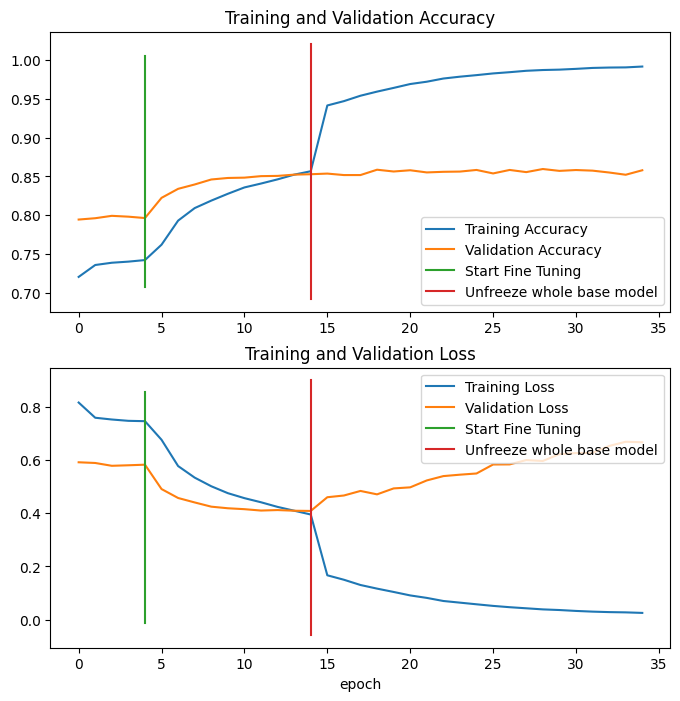

In [366]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([5-1,5-1],
          plt.ylim(), label='Start Fine Tuning')
plt.plot([15-1,15-1],
          plt.ylim(), label='Unfreeze whole base model')          
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([5-1,5-1],
         plt.ylim(), label='Start Fine Tuning')
plt.plot([15-1,15-1],
          plt.ylim(), label='Unfreeze whole base model')  
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Looking at the accuracy values, we can see that the training accuracy steadily increases with each epoch, reaching a high value of 0.9920. On the other hand, the validation accuracy fluctuates slightly around 0.85-0.86, without showing a significant improvement. This indicates that the model is learning the training data very well but is not generalizing as effectively to unseen validation data. This discrepancy suggests a potential for overfitting.

We could further finetune the model by applying more regularization techniques such as L1 and L2 regularization or adding more Dropout layer. However, we leaves the task as future work because of the time constraint.

### Evaluate the final model and future improvement

We got an accuracy of **86.35%** on the public set, achieving the 5th position on the leaderboard. The accuracy with regard to the private test set is **86.8%**, ranking 8th on the leaderboard. 

We will examine the confusion matrix on the validation set to see what we should improve in the predictions:

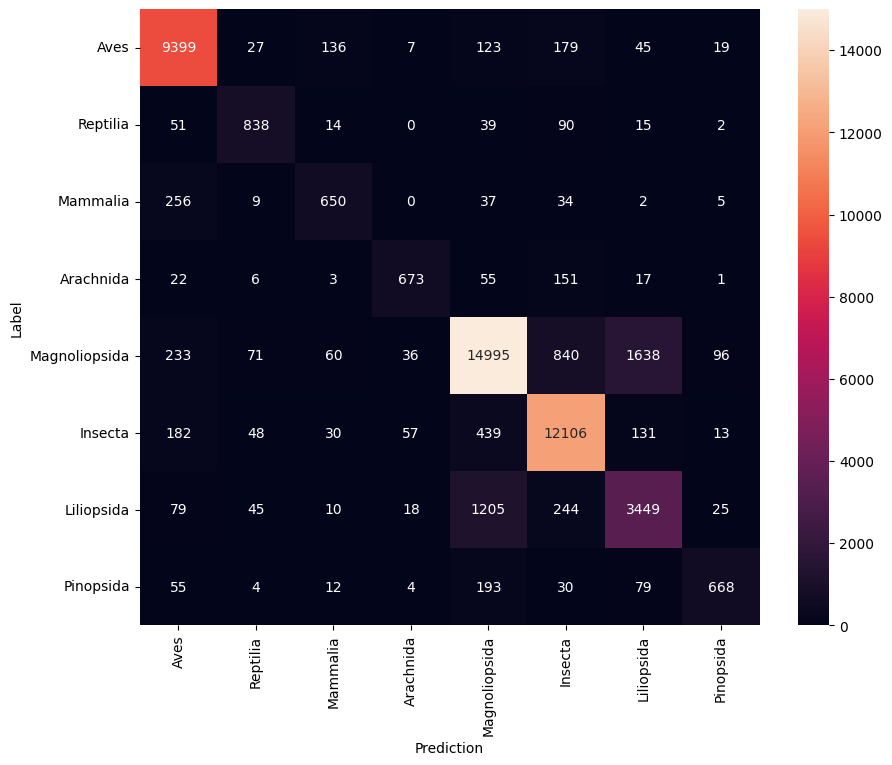

In [ ]:
show_confusion_matrix(confusion_matrix, coarse_names)



The provided confusion matrix represents the accuracy between classes and the frequent mistaken classes.
1. Class 'Aves':
   - Correctly predicted instances: 9,399
   - Most frequently mistaken for: 'Magnoliopsida' (123 instances), 'Insecta' (179 instances)
   - Accuracy within the class: 9,399 / (9,399 + 27 + 136 + 7 + 123 + 179 + 45 + 19) = 97.75%

2. Class 'Reptilia':
   - Correctly predicted instances: 838
   - Most frequently mistaken for: 'Aves' (51 instances), 'Magnoliopsida' (39 instances), 'Insecta' (90 instances)
   - Accuracy within the class: 838 / (838 + 51 + 14 + 0 + 39 + 90 + 15 + 2) = 78.96%

3. Class 'Mammalia':
   - Correctly predicted instances: 650
   - Most frequently mistaken for: 'Aves' (256 instances), 'Magnoliopsida' (37 instances)
   - Accuracy within the class: 650 / (650 + 256 + 9 + 0 + 37 + 34 + 2 + 5) = 65.06%

4. Class 'Arachnida':
   - Correctly predicted instances: 673
   - Most frequently mistaken for: 'Magnoliopsida' (55 instances), 'Insecta' (151 instances)
   - Accuracy within the class: 673 / (673 + 22 + 6 + 3 + 55 + 151 + 17 + 1) = 76.55%

5. Class 'Magnoliopsida':
   - Correctly predicted instances: 14,995
   - Most frequently mistaken for: 'Insecta' (840 instances), 'Liliopsida' (1,638 instances), 'Pinopsida' (96 instances)
   - Accuracy within the class: 14,995 / (14,995 + 233 + 71 + 60 + 36 + 840 + 1,638 + 96) = 89.29%

6. Class 'Insecta':
   - Correctly predicted instances: 12,106
   - Most frequently mistaken for: 'Magnoliopsida' (439 instances), 'Liliopsida' (131 instances)
   - Accuracy within the class: 12,106 / (12,106 + 182 + 48 + 30 + 57 + 439 + 131 + 13) = 91.16%

7. Class 'Liliopsida':
   - Correctly predicted instances: 3,449
   - Most frequently mistaken for: 'Magnoliopsida' (1,205 instances), 'Insecta' (244 instances)
   - Accuracy within the class: 3,449 / (3,449 + 79 + 45 + 10 + 18 + 1,205 + 244 + 25) = 63.83%

8. Class 'Pinopsida':
   - Correctly predicted instances: 668
   - Most frequently mistaken for: 'Magnoliopsida' (193 instances), 'Insecta' (30 instances), 'Liliopsida' (79 instances)
   - Accuracy within the class: 668 / (668 + 55 + 4 + 12 + 4 + 193 + 30 + 79) = 66.40%

We can see that there are many classes are frequently mistakenly classify as Magnoliopsida. This may due to the fact that the dataset is highly unbalanced.

In [9]:
predictions = model_coarse.predict(val_ds_coarse)

2023-06-02 12:30:02.581188: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


782/782 [==============================] - 132s 167ms/step


The next figure show the model predictions on several image from the validation set. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

The figure shows the problem of the current model, where many images are mislabel as Magnoliopsida. 

This suggest that we can improve our predictions by ensemble methods: Combine multiple models to make predictions. We could train another model specific in classifying only Magnoliopsida, combining with our exsisting model to improve the overall accuracy.

In [224]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(coarse_names[predicted_label],
                                100*np.max(predictions_array),
                                coarse_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

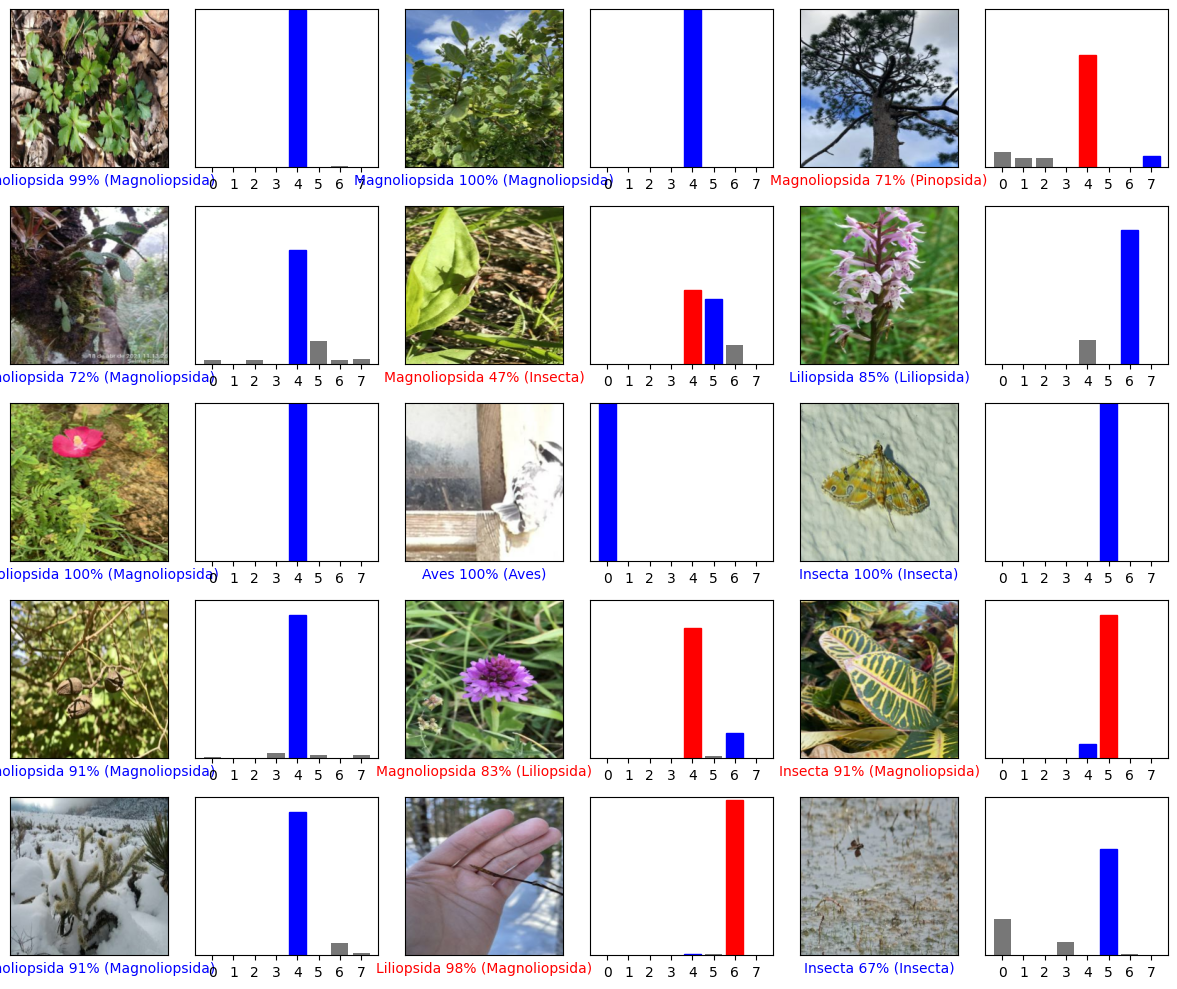

In [34]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for images, labels in val_ds_coarse.take(1):
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions[i], labels, images)
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions[i], labels)
plt.tight_layout()

plt.show()


We conclude our work and make the prediction for Kaggle

In [ ]:
y_proba_test = model_coarse.predict(test_ds_coarse)
y_pred = y_proba_test.argmax(axis=-1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "coarse"] = y_pred
test_csv = test_csv.drop(columns=['fine'])
pred_file = "46864660-deep-coarse.csv"
test_csv.to_csv(pred_file, index=False)

## Fine-grained

The final model that produced the best-performing predictions for the Kaggle submission was a fine tuned InceptionV3 model.  
We got an accuracy of **59.14%** on the public set, achieving the 5th position on the leaderboard. The accuracy with regard to the private test set is **61.67%**, ranking 5th on the leaderboard.

The following code create the dataset for tensorflow model

In [35]:
batch_size = 64
img_size = 224
fine_grain = True
num_classes = 50 if fine_grain else 8


In [37]:
train_ds_fine = create_dataset_tf(
    'train', fine_grained=fine_grain, batch_size=batch_size, image_size=img_size)
val_ds_fine = create_dataset_tf(
    'val', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)
test_ds_fine = create_dataset_tf(
    'test', fine_grained=fine_grain, batch_size=batch_size,  image_size=img_size)


The model structure is the same as the coarse-grained model, the only different is the number of output in the prediction layer, which is now 50 for fine-grained classes.

In [41]:
# create the base pre-trained model
base_model_fine = tf.keras.applications.EfficientNetB1(
    weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3),)

# freeze the base model
for layer in base_model_fine.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
x = base_model_fine(x)

# add a global spatial average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x) 
# and a logistic layer
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

# create the base pre-trained model
model_fine = tf.keras.Model(inputs=inputs, outputs=predictions)
model_fine.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb1 (Functional)  (None, 7, 7, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 50)                64050     
                                                             

The final model after finetuning will have more trainable params as follow

In [187]:
model_fine = tf.keras.saving.load_model("models/InceptionV3_fine")

In [145]:
model_fine.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 50)                102450    
                                                             

In [188]:
model_fine.evaluate(val_ds_fine)

782/782 [==============================] - 138s 174ms/step - loss: 1.4612 - accuracy: 0.5904


[1.4612091779708862, 0.5904200077056885]

## Notes on the Deep Learning Fine Model

1. Since this is a similar problem with the classifying coarse-label task, we will choose the transfer learning approach, which was perform rather well in the previous task.
2. The image input is exactly the same as the input for the coarse-label task, only the label is different. We could try transfer learning from the fitted model for coarse, since it learned some pattern about the image already. Then, we will try to finetune it for adaptting with the fine label version.

We first create our model base on the fitted coarse model and train for a few epochs

In [147]:
# the base model is the previous coarse model
base_model_fine = tf.keras.saving.load_model("models/InceptionV3_coarse")

In [149]:
model_fine = tf.keras.Sequential()

# freeze the base model
for layer in base_model_fine.layers:
    layer.trainable = False

# copy every layer from the basemodel except the last output layer
for layer in base_model_fine.layers[:-2]: # go through until last layer
    model_fine.add(layer)

# create new prediction layer
predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(base_model_fine.layers[-2].output)

# create the base pre-trained model
model_fine = tf.keras.Model(inputs=base_model_fine.input, outputs=predictions)
model_fine.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                                 
Total params: 21,905,234
Trainable params: 102,450
Non-trainable params: 21,802,784
_________________________________________

In [ ]:
model_fine.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history_fine = model_fine.fit(train_ds_fine, epochs=5,
                        validation_data=val_ds_fine)

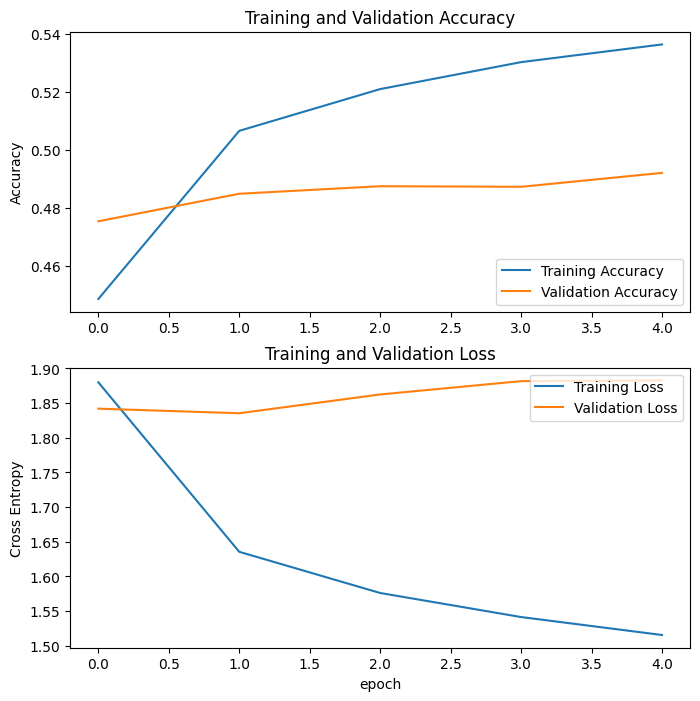

In [152]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_cnn_coarse.history['loss']
val_loss = history_cnn_coarse.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


As we expected, the model fit with the new labels rather quick. However, the validation accuracy and loss curve is flat, which suggest that the model does not improve much in generalisation. We will now unfreeze the whole base model and fit for a few more epochs.

In [154]:

for layer in model_fine.layers:
    layer.trainable = True
# set the base model to inceptionV3 model and unfreeze layer
base_model_fine = model_fine.layers[2]
for layer in base_model_fine.layers:
    layer.trainable = True
model_fine.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 50)                102450    
                                                                 
Total params: 21,905,234
Trainable params: 21,870,802
Non-trainable params: 34,432
__________________________________________

In [155]:
model_fine.compile(
    optimizer="Adam",
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [ ]:
history_fine_finetune = model_fine.fit(train_ds_fine, epochs=10, validation_data=val_ds_fine, callbacks=[
                        early_stopping_cb, lr_scheduler])


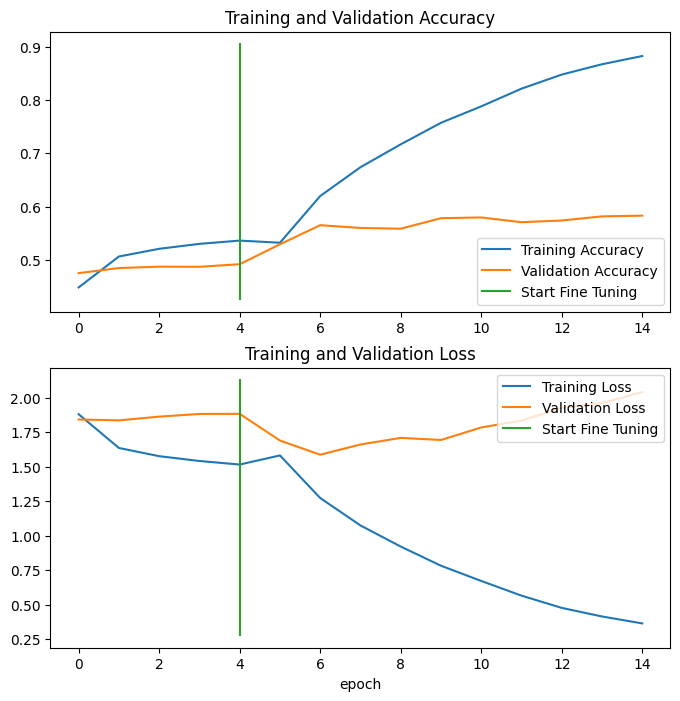

In [219]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([5-1,5-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([5-1,5-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

- The training accuracy steadily increases from 0.4485 to 0.8824, which indicates that the model is learning and improving its predictions on the training data.
- The validation accuracy also shows an increasing trend from 0.5065 to 0.5831. However, it does not reach the same level as the training accuracy, suggesting some degree of underfitting.
- The training loss decreases consistently from 1.88 to 0.3651, indicating that the model is effectively reducing the training error.
- The validation loss exhibits a fluctuating pattern, but generally increases from 1.842 to 2.0407. The increasing trend suggests that the model struggles to generalize well to unseen data.

Overall, the increasing validation loss and the gap between training and validation accuracy indicate the presence of some degree of underfitting. It might be beneficial to consider model adjustments, such as increasing model complexity or applying more regularization techniques, to improve the model's generalization performance.

### Evaluate the final model and future improvement

We got an accuracy of **59.14%** on the public set, achieving the 5th position on the leaderboard. The accuracy with regard to the private test set is **61.67%**, ranking 5th on the leaderboard.

The model accuracy score is average, suggesting that we could further work on the task. For the future work, we could try applying more regularizaiton techniques, using different pretrained model architectures or collect more data.

For now, we conclude our work and make the prediction for Kaggle

In [ ]:
y_proba_test = model_fine.predict(test_ds_fine)
y_pred = y_proba_test.argmax(axis=-1)
test_csv = pd.read_csv(root / f"test.csv")
test_csv.loc[:, "fine"] = y_pred
test_csv = test_csv.drop(columns=['coarse'])
pred_file = "46864660-deep-fine.csv"
test_csv.to_csv(pred_file, index=False)

# Discussion of Model Performance and Implementation

Comparing my final conventional and deep learning models

* With the coarse labels: 
    - The deep learning one performed better by 39% on the public test set.  The deep learning model ranked 5 out of 67 on the public test set, with the top-performing system having 93.54% accuracy, and a majority class baseline having 70% accuracy.
    - The deep learning one performed better by 50% on the private test set.  The deep learning model ranked 8 out of 54 on the private test set, with the top-performing system having 93.73% accuracy, and a majority class baseline having 70% accuracy.

* With the fine labels: 
    - The deep learning one performed better by 50% on the public test set.  The deep learning model ranked 5 out of 57 on the public test set, with the top-performing system having 77.31% accuracy, and a majority class baseline having 32% accuracy.
    - The deep learning one performed better by 55%% on the private test set.  The deep learning model ranked 5 out of 54 on the private test set, with the top-performing system having 77.46% accuracy, and a majority class baseline having 30% accuracy.

We can see the detail comparision in the next table

In [218]:
final_dict = {
    'Type': ['Conventional', 'Conventional',
                  'Deep Learning', 'Deep Learning'],
    'Best Models': ['Random Forest Classifier', 'Extra-tree Classifier',
                  'InceptionV3 finetuned', 'InceptionV3 finetuned'],
    'Label': ['Coarse', 'Fine', 'Coarse', 'Fine'],
    'Score Validation Set': ['47.28%', '6.8%', '85.56%', '59.04%'],
    'Score Public Set': ['47.34%', '6.57%', '86.35%', '59.13%'],
    'Score Private Set': ['45.27%', '6.87%','86.8%', '61.67%'],
    'Top Kaggle Public Score': ['', '', '93.54%','77.31%'],
    'Top Kaggle Private Score': ['', '', '93.73%', '77.46%']
}
final_df = pd.DataFrame(final_dict)
final_df


Type               Best Models   Label Score Validation Set   
0   Conventional  Random Forest Classifier  Coarse               47.28%  \
1   Conventional     Extra-tree Classifier    Fine                 6.8%   
2  Deep Learning     InceptionV3 finetuned  Coarse               85.56%   
3  Deep Learning     InceptionV3 finetuned    Fine               59.04%   

  Score Public Set Score Private Set Top Kaggle Public Score   
0           47.34%            45.27%                          \
1            6.57%             6.87%                           
2           86.35%             86.8%                  93.54%   
3           59.13%            61.67%                  77.31%   

  Top Kaggle Private Score  
0                           
1                           
2                   93.73%  
3                   77.46%

Looking at the score between each set, we can make the following comments:

1. Conventional Models:
   - Random Forest Classifier (Coarse): The model achieved a validation set score of 47.28% and a public test set score of 47.34%. These scores indicate a similar performance on both sets, suggesting that the model generalized adequately to the unseen public test data. The close scores on the validation and public sets indicate that the model's performance is consistent across different subsets of the data.

   - Extra-tree Classifier (Fine): The model achieved a validation set score of 6.8% and a public test set score of 6.57%. Similar to the previous model, the scores are close, indicating consistent performance. However, the overall performance is quite low, suggesting that the model may struggle to capture the complexities of the fine-grained classification task.

2. Deep Learning Models:
   - InceptionV3 finetuned (Coarse): In this case, the model performed slightly better on the public test set compared to the validation set. This suggests that the model's performance on the unseen public test data was slightly better than on the validation data. The close scores indicate good generalization ability, as the model performed consistently well on both sets. The Top Kaggle scores also indicate that the model performed well compared to other submissions.
   
   - InceptionV3 finetuned (Fine): The model achieved a validation set score of 59.04% and a public test set score of 59.13%. These scores are quite close, indicating consistent performance on both sets. However, the overall performance is lower compared to the coarse-grained task, suggesting that fine-grained classification may be more challenging. The Top Kaggle scores indicate that the model's performance is relatively lower compared to other submissions.

In summary, there is no indication of overfitting based on the scores. The models demonstrated good generalization ability and performed consistently accross all sets and in the Kaggle competition.

- As we can observe, the differences between accuracies are huge, suggesting that deep learning
is better to face a complex problem and imbalanced data. When training the deep learning, we faced overtting problems. As we could not add more
training data we applied data augmentation, used dropout regularization, compared results with different architectures, and used early stopping. In conclusion, the final model handled quite good the overtting problem.

- We could not train the full set of data for the Conventional model due to time constraint and computational power limitation.
- We could not try different architecture like EfficientNet or ResNet for Deep Learning due to computational power limitation.

- We also suggest some work for future investigation. For the Conventional model, training with the full train dataset will be a priority.
For the Deep Learning model, we could improve the overall performance through ensemble learning or image generation.